# Leaf Classification Project


In [1]:
epochs_optimizer = 10 # for the result of the project I chose 10
trials_optimizer = 40 # for the number of trial in the optimizer is 40
epochs_training = 100  # for the number of epochs for the training I chose 100


## Libraries

In [2]:
!pip install kaggle
!pip install optuna



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.6 MB/s eta 0:00:00


In [3]:
from google.colab import files
import os
import re
import pandas as pd
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from PIL import Image
import shutil
import torch.nn as nn
from torch.nn import DataParallel
from torchsummary import summary
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import time
import optuna
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt








## Get the Dataset from kaggle

In [4]:
os.environ['KAGGLE_USERNAME'] = "miguelecg"
os.environ['KAGGLE_KEY'] = "8eb663834c85a99719d10a026c691a60"
# !kaggle datasets download -d csafrit2/plant-leaves-for-image-classification
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification --unzip -p "/content/dataset"


100% 6.54G/6.56G [00:53<00:00, 302MB/s]
100% 6.56G/6.56G [00:53<00:00, 133MB/s]


Due to the dataset have information of sick and helthy plants for all of the classes, I just delete the information about the sick ones in order to train the model without the noise of the sickness

In [5]:
# Get path
path = os.getcwd()
print(path)

/content


In [6]:

# Especifica la ruta de la carpeta que deseas eliminar
for group in ['test','train','valid']:
  for folder in os.listdir('/content/dataset/Plants_2/' + group):
    if 'diseased' in folder:
      path = '/content/dataset/Plants_2/' + group +'/'+folder
      shutil.rmtree(path)
      # print(path)




## Creation of dataset

Due to the resize is one of the longest process in the model ans this process is made everytime that I take a new bath for the model, I decided to reduce the size of the files from the beging, before to take then into the model and saving them with the size of interes, in this way I just resize the file once instead of once per epoch


In [7]:
# Get path
path = os.getcwd()
print(path)

/content


In [8]:
# Define the resize transform
resize = transforms.Compose([
    transforms.Resize((224, 224))
])


  0%|          | 0/3 [00:00<?, ?iter/s]

Clases:   0%|          | 0/11 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Clases:   0%|          | 0/11 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/277 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/267 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/123 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/149 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/312 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/159 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/210 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/93 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/137 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/168 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/268 [00:00<?, ?iter/s]

Clases:   0%|          | 0/11 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

Imagenes:   0%|          | 0/5 [00:00<?, ?iter/s]

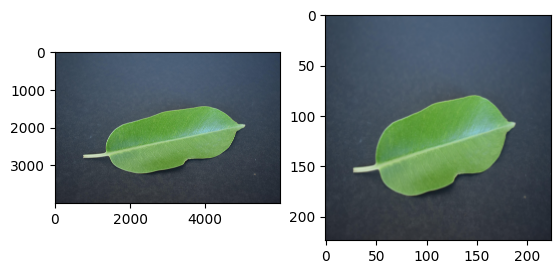

In [9]:
# Specify the path of the folder to transform
img_path = '/content/dataset/Plants_2/'
new_dir = '/content/dataset/Plants_2_resize/'

for group in tqdm_notebook(['test','train','valid'], unit='iter'):
  for folder in tqdm_notebook(os.listdir(img_path + group), desc='Clases', leave=False, unit='iter') :
    os.makedirs(new_dir + group + '/' + folder, exist_ok=True)
    for imag in tqdm_notebook(os.listdir(img_path + group + '/' + folder), desc='Imagenes',unit='iter',  leave=False):
      image = Image.open(img_path + group + '/' + folder+'/'+imag)
      transformed_image = resize(image)
      transformed_image.save(new_dir + group + '/' + folder+ '/' + imag)
      # break
    # break
  # break


fig, axes = plt.subplots(1, 2)

axes[0].imshow(image)
axes[1].imshow(transformed_image)


In [10]:
shutil.copytree('/content/dataset/Plants_2_resize', '/content/drive/MyDrive/LAB/try/')


'/content/drive/MyDrive/LAB/try/'

## Load data (just do this if the data is alredy downloaded and resized
To avoid to work in the last preprocesing step, I decided to storage the preprocess dataset in my google account, it is just to avoid to do the resize everytime that restart the session on colab



In [4]:
# Spedify the new location of the data in the memory of the colab sesion
folder_path = '/content/drive/MyDrive/LAB/Dataset'
destination_path = '/content/dataset/Plants_2_resize'
shutil.rmtree(destination_path, ignore_errors=True)

shutil.copytree(folder_path, destination_path)


'/content/dataset/Plants_2_resize'

## Transform data

After I get the data in the temporal memory of colab, I apply the transforms to generate the data aumentation ot the dataset with the flip of the images and also the normalization of the data in order to avoid

In [5]:
# Get path
path = os.getcwd()
print(path)

/content


In [6]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Data aumentation
    transforms.RandomVerticalFlip(), # Data aumentation
    transforms.RandomRotation(degrees=30), # Data aumentation
    transforms.ToTensor(),  # Convertimos las imágenes en tensores
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Data normalization
])

transform = transforms.Compose([
    transforms.ToTensor(),  # Convertimos las imágenes en tensores
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Data normalization
])

In [7]:
# Creation of the dataset using the clase ImageFolder
dataset_trainig = datasets.ImageFolder(root= path+"/dataset/Plants_2_resize/train", transform=transform_train)
dataset_validation = datasets.ImageFolder(root= path+"/dataset/Plants_2_resize/valid", transform=transform)
dataset_test = datasets.ImageFolder(root= path+"/dataset/Plants_2_resize/test", transform=transform)


In [8]:
# Redifine the clases just with the name of the plants
new_classes = {}
new_class_idx = 0
for original_class, original_idx in dataset_trainig.class_to_idx.items():
    plant_name = original_class.split(' ')[0] # obtiene el nombre de la planta
    if plant_name not in new_classes:
        new_classes[plant_name] = new_class_idx
        new_class_idx += 1
    new_idx = new_classes[plant_name]

    # mapea la clase original a la nueva clase correspondiente a la planta
    dataset_trainig.samples = [(path, new_idx) if idx == original_idx else (path, idx) for path, idx in dataset_trainig.samples]
    dataset_trainig.classes = list(new_classes.keys())
    dataset_trainig.class_to_idx = new_classes

    # mapea la clase original a la nueva clase correspondiente a la planta en test
    dataset_test.samples = [(path, new_idx) if idx == original_idx else (path, idx) for path, idx in dataset_test.samples]
    dataset_test.classes = list(new_classes.keys())
    dataset_test.class_to_idx = new_classes

    # mapea la clase original a la nueva clase correspondiente a la planta en valid
    dataset_validation.samples = [(path, new_idx) if idx == original_idx else (path, idx) for path, idx in dataset_validation.samples]
    dataset_validation.classes = list(new_classes.keys())
    dataset_validation.class_to_idx = new_classes

In [9]:
N_clases = len(dataset_trainig.class_to_idx.items())
img_input_size = dataset_trainig[0][0].shape


print(f'Total Clases: {N_clases}')
print(dataset_trainig.class_to_idx.items())
print(dataset_test.class_to_idx.items())
print(dataset_validation.class_to_idx.items())
print(f'size of training dataset: {len(dataset_trainig)}')
print(f'size of Validation dataset: {len(dataset_validation)}')
print(f'size of test dataset: {len(dataset_test)}')

Total Clases: 11
dict_items([('Alstonia', 0), ('Arjun', 1), ('Basil', 2), ('Chinar', 3), ('Gauva', 4), ('Jamun', 5), ('Jatropha', 6), ('Lemon', 7), ('Mango', 8), ('Pomegranate', 9), ('Pongamia', 10)])
dict_items([('Alstonia', 0), ('Arjun', 1), ('Basil', 2), ('Chinar', 3), ('Gauva', 4), ('Jamun', 5), ('Jatropha', 6), ('Lemon', 7), ('Mango', 8), ('Pomegranate', 9), ('Pongamia', 10)])
dict_items([('Alstonia', 0), ('Arjun', 1), ('Basil', 2), ('Chinar', 3), ('Gauva', 4), ('Jamun', 5), ('Jatropha', 6), ('Lemon', 7), ('Mango', 8), ('Pomegranate', 9), ('Pongamia', 10)])
size of training dataset: 2163
size of Validation dataset: 55
size of test dataset: 55


## DataLoader

In [10]:
# creation of the dataloader using the dataset
dataloader_trainig = torch.utils.data.DataLoader(dataset_trainig, batch_size=32, shuffle=True)
dataloader_validation = torch.utils.data.DataLoader(dataset_validation,batch_size=32, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [11]:
# test to check how fast I can access to the batch in the dataloader
a = 0
for batch in dataloader_test:
  x, y = batch
  print(x.device)
  print(y.shape)
  a += 1
  if a >=3:
    break


cpu
torch.Size([32])
cpu
torch.Size([23])


## Model


I chose a convulative network infrastructure for the image classification problem because this type of model is one of them that has great advantages for the parallel computing user because it consists of a large number of matrix multiplications that perfectly allow to be parallelized to increase the speed of training the model

In [12]:
class Leaves_classifier(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, N_clases, dropout_prob=0.2):
        super(Leaves_classifier, self).__init__()

        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 128, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=1),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(128*29*29, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, N_clases)
            # Reminder: The softmax is included in the loss, do not put it here
        )
        self.dropout = nn.Dropout(dropout_prob)


    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.dropout(output)
        output = self.classifier(output) # we compute the output of the fc layers
        return output


In [13]:
# Move the model to the device specified
dropout = 0.2
model = Leaves_classifier(N_clases, dropout)

# Check if there are GPUs available
if torch.cuda.is_available():
    device = 'cuda'
    # Si hay múltiples GPUs disponibles, paralelizar el modelo
    if torch.cuda.device_count() > 1:
        model = DataParallel(model)
else:
    device = 'cpu'


model = model.to(device)

# summary of the modelo
summary(model, input_size= img_input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 29, 29]               0
          Dropout-10               [-1, 107648]               0
           Linear-11                 [-1, 1000]     107,649,000
             ReLU-12                 [-1, 1000]               0
           Linear-13                  [-1, 100]         100,100
             ReLU-14                  [

## Optimize the hyperparameters

I defined a Train_Model, Evaluation Model and optimization function to define the optimization of the hyperparameters

In [14]:
def Train_Model(model, dataloader, optimizer, criterion, device):
  model.train() # set the model in the training mode in order to activate the dropout
  total_loss = 0.0
  correct = 0
  total_samples = 0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device) # pass the variable to the gpu

    optimizer.zero_grad() # restard the gradients

    output = model(inputs) # get the outputs form the model
    loss = criterion(output, labels) # compute the loss function

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    _, predicted = output.max(1)
    correct += predicted.eq(labels).sum().item() # compute how many correct prediction were made in the data
    total_samples += labels.size(0)  # compute how many images we processed

  train_loss = total_loss /len(dataloader) # compute the average loss for batch
  train_accuracy = (correct /total_samples)*100

  return train_loss, train_accuracy


In [15]:
def Validate_Model(model, dataloader, criterion, device):
  model.eval()
  total_loss = 0.0
  correct = 0
  total_samples = 0

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      total_loss += loss.item()
      _, predicted = outputs.max(1)
      correct += predicted.eq(labels).sum().item()
      total_samples += labels.size(0)

  val_loss = total_loss / len(dataloader)
  val_accuracy = (correct /total_samples)*100

  return val_loss, val_accuracy

In [16]:
def Optimize_hyp(trial, dataloader_trainig, dataloader_validation):
  alpha = trial.suggest_float('alpha', 1, 100)
  beta = trial.suggest_float('beta', 0.1, 1.0)
  mu0 = trial.suggest_float('mu0', 0.001, 0.1)
  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

  model = Leaves_classifier(N_clases, dropout_rate)
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=mu0, momentum=0.9)

  epochs = epochs_optimizer  # I choose 6 epochs because I notice that until this point the model usually increase the accuracy, after that I could have some decreased epochs and the idea is find the set that provide a faster convergence
  scheduler = torch.optim.lr_scheduler.LambdaLR( optimizer,
        lambda e: mu0 / (1 + alpha * e / epochs) ** beta
    )

  #train the model and evaluated in the validation set
  for epoch in range(epochs):
    Training_loss, Training_accuracy = Train_Model(model, dataloader_trainig, optimizer, criterion, device)
    Validation_loss, Validation_accuracy = Validate_Model(model, dataloader_validation, criterion, device)
    scheduler.step()

    # # Print the metrics
    # print(f"Epoch {epoch + 1}/{epochs}")
    # print(f"Train Loss: {Training_loss:.4f}, Train Accuracy: {Training_accuracy:.2f}")
    # print(f"Val Loss: {Validation_loss:.4f}, Val Accuracy: {Validation_accuracy:.2f}")

  return Validation_accuracy




In [17]:
# create an optimization study to find the optimal hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: Optimize_hyp(trial, dataloader_trainig, dataloader_validation), n_trials=trials_optimizer)

# Get the best hyperparameter find by optuna
best_params = study.best_params
print("The best hyperparameters:")
print(best_params)

[I 2023-09-07 15:23:16,042] A new study created in memory with name: no-name-5461b983-9e03-471b-be92-2aaa73fde3ee
[I 2023-09-07 15:24:43,902] Trial 0 finished with value: 67.27272727272727 and parameters: {'alpha': 28.50903557184785, 'beta': 0.5834472801889915, 'mu0': 0.09198329946700384, 'dropout_rate': 0.49792595242408455}. Best is trial 0 with value: 67.27272727272727.
[I 2023-09-07 15:26:11,382] Trial 1 finished with value: 9.090909090909092 and parameters: {'alpha': 63.064008253947094, 'beta': 0.5643968383823785, 'mu0': 0.006068048728068496, 'dropout_rate': 0.19777603447780315}. Best is trial 0 with value: 67.27272727272727.
[I 2023-09-07 15:27:37,838] Trial 2 finished with value: 32.72727272727273 and parameters: {'alpha': 35.66258528773493, 'beta': 0.5653066245715322, 'mu0': 0.03256365770200057, 'dropout_rate': 0.34345893661843446}. Best is trial 0 with value: 67.27272727272727.
[I 2023-09-07 15:29:04,399] Trial 3 finished with value: 18.181818181818183 and parameters: {'alpha':

The best hyperparameters:
{'alpha': 48.09925446186721, 'beta': 0.30298049483021133, 'mu0': 0.07596658696049113, 'dropout_rate': 0.4416633372553593}


## Training


In [17]:
def Test_Model(model, dataloader, criterion, device):
  model.eval()
  total_loss = 0.0
  correct = 0
  total_samples = 0

  true_labels = []
  predicted_labels = []

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      total_loss += loss.item()
      _, predicted = outputs.max(1)
      correct += predicted.eq(labels).sum().item()
      total_samples += labels.size(0)

      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())

  Test_loss = total_loss / len(dataloader)
  Test_accuracy = (correct /total_samples)*100

  return Test_loss, Test_accuracy, true_labels, predicted_labels

In [19]:
# Results of the optimization part
# best_params = {'alpha': 33.81642879551388, 'beta': 0.23748057499338474, 'mu0': 0.08737395109903834, 'dropout_rate': 0.7075835756705534}
# best_params = {'alpha': 99.16836552922268, 'beta': 0.29203441966096416, 'mu0': 0.09766451510374305, 'dropout_rate': 0.4920577605211014}
# best_params = {'alpha': 81.85351025780467, 'beta': 0.2998826862026148, 'mu0': 0.08518835722241025, 'dropout_rate': 0.30573468987484304}
# best_params = {'alpha': 1.519307525506162, 'beta': 0.5817971835591592, 'mu0': 0.07726896497993022, 'dropout_rate': 0.43441280519281095} ## 70.9090909090909
# best_params = {'alpha': 2.0124389101746942, 'beta': 0.11847455746806501, 'mu0': 0.05610494936858862, 'dropout_rate': 0.20296744794707428}  ## 70.9090909090909
best_params = {'alpha': 48.09925446186721, 'beta': 0.30298049483021133, 'mu0': 0.07596658696049113, 'dropout_rate': 0.4416633372553593}


In [20]:
epochs = epochs_training

model = Leaves_classifier(N_clases, best_params['dropout_rate'])
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=best_params['mu0'], momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: best_params['mu0'] / (1 + best_params['alpha'] * e / epochs) ** best_params['beta']
)


train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_accuracy = 0.0
counter = 0

for epoch in tqdm_notebook(range(epochs), unit='iter'):

  Training_loss, Training_accuracy = Train_Model(model, dataloader_trainig, optimizer, criterion, device)
  Test_loss, Test_accuracy, true_labels, predicted_labels = Test_Model(model, dataloader_test, criterion, device)

  train_losses.append(Training_loss)
  train_accuracies.append(Training_accuracy)
  test_losses.append(Test_loss)
  test_accuracies.append(Test_accuracy)

  print(f'Epoch {epoch}, Train Loss: {Training_loss:.4f}, Train Accuracy: {Training_accuracy:.2f}')
  print(f"Test Loss: {Training_loss:.4f}, Test Accuracy: {Test_accuracy:.2f}")

  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")


  if Test_accuracy > best_accuracy:
    best_accuracy = Test_accuracy
    # Save the model and optimizer state
    torch.save(
        {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, '/content/drive/MyDrive/LAB/Best_Leave_Model.pth')
    counter = 0

  else:
    counter +=1
  if counter >= 10 and epoch > 50:
    break


  0%|          | 0/100 [00:00<?, ?iter/s]

Epoch 0, Train Loss: 2.3303, Train Accuracy: 18.17
Test Loss: 2.3303, Test Accuracy: 21.82
	Learning rate = 0.005123550674323494
Epoch 1, Train Loss: 1.8920, Train Accuracy: 32.50
Test Loss: 1.8920, Test Accuracy: 27.27
	Learning rate = 0.004705048892972261
Epoch 2, Train Loss: 1.5079, Train Accuracy: 47.71
Test Loss: 1.5079, Test Accuracy: 34.55
	Learning rate = 0.004402640154425219
Epoch 3, Train Loss: 1.3589, Train Accuracy: 52.29
Test Loss: 1.3589, Test Accuracy: 56.36
	Learning rate = 0.004169313173871967
Epoch 4, Train Loss: 1.1839, Train Accuracy: 58.53
Test Loss: 1.1839, Test Accuracy: 58.18
	Learning rate = 0.003981306041513199
Epoch 5, Train Loss: 1.1362, Train Accuracy: 59.73
Test Loss: 1.1362, Test Accuracy: 63.64
	Learning rate = 0.003825065667091109
Epoch 6, Train Loss: 1.0071, Train Accuracy: 64.68
Test Loss: 1.0071, Test Accuracy: 72.73
	Learning rate = 0.003692187790248207
Epoch 7, Train Loss: 0.9078, Train Accuracy: 68.38
Test Loss: 0.9078, Test Accuracy: 76.36
	Learn

## Results

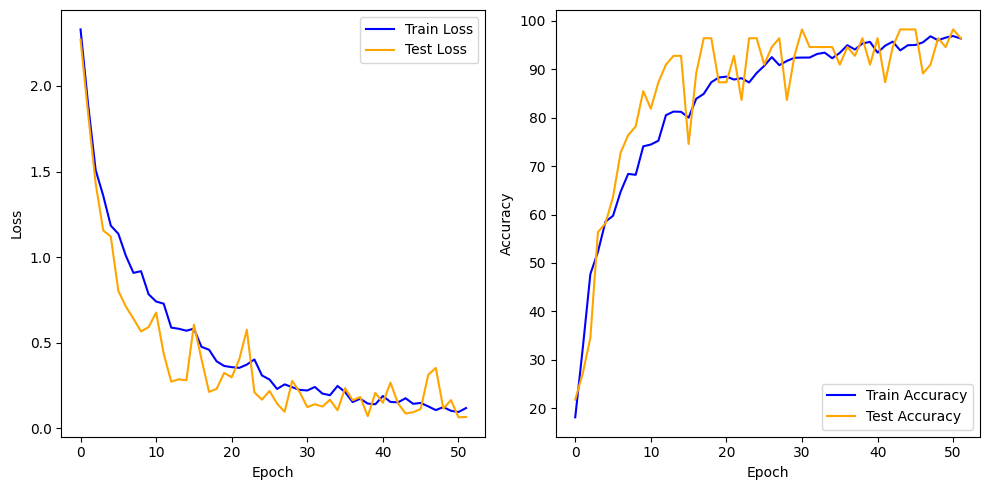

In [21]:
# Gráficas de Loss y Accuracy
plt.figure(figsize=(10, 5))

# Loss Function
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss', color='blue')
plt.plot(range(len(train_losses)), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(test_accuracies)), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

According with this curves there is no signal of overfitting due to the behaviour of the model for trainig and test set is similar and has the same pattern.

In [22]:

# Redefine the model and the optimizer with the structure define before
model1 = Leaves_classifier(N_clases)
model1 = model.to(device)

optimizer1 = torch.optim.SGD(model.parameters(), lr=1.0, momentum=0.9)


checkpoint = torch.load('/content/drive/MyDrive/LAB/Best_Leave_Model.pth',map_location=torch.device(device))
model1.load_state_dict(checkpoint['model_state_dict'])
optimizer1.load_state_dict(checkpoint['optimizer_state_dict'])

Test Loss: 0.1180, Test Accuracy: 98.18


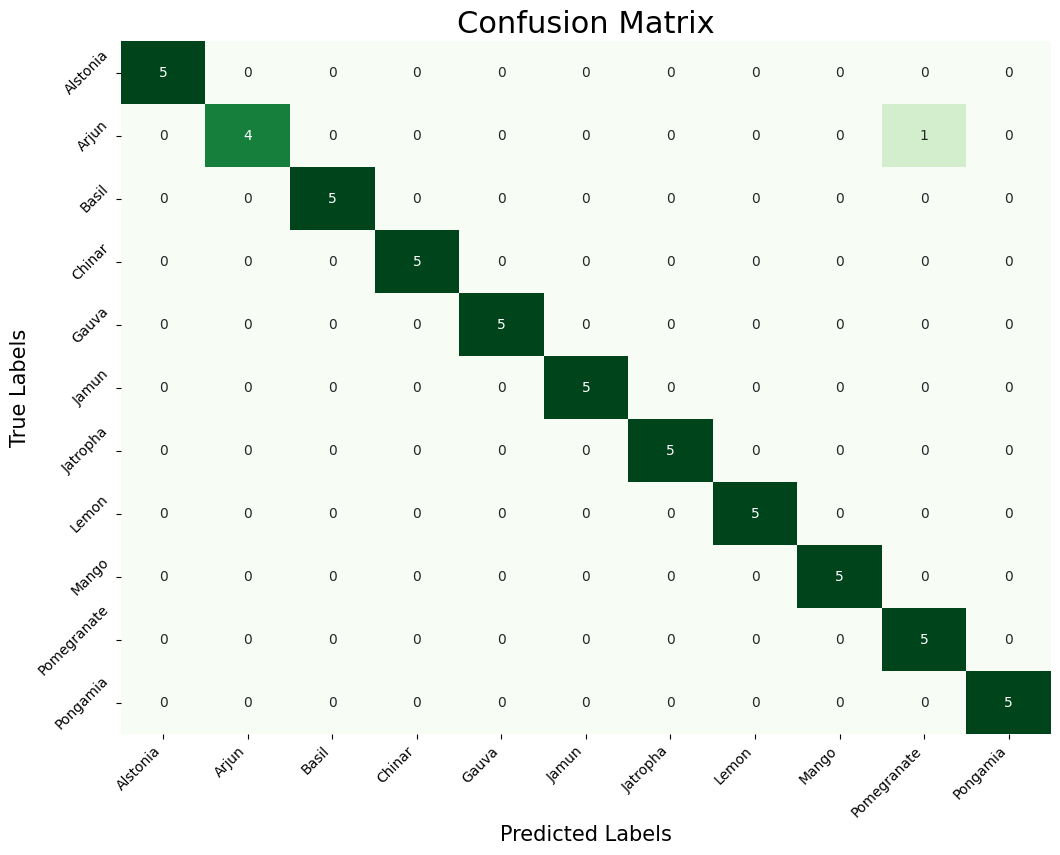

In [23]:
Test_loss, Test_accuracy, true_labels, predicted_labels = Test_Model(model, dataloader_test, criterion, device)
print(f"Test Loss: {Training_loss:.4f}, Test Accuracy: {Test_accuracy:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

num_classes = len(dataset_test.classes)
plt.figure(figsize=(12, 9))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted Labels', size = 15)
plt.ylabel('True Labels', size = 15)
ax.set_xticklabels(dataset_test.classes, rotation=45, ha='right', size = 10)
ax.set_yticklabels(dataset_test.classes, rotation=45, ha='right', size = 10)
plt.title('Confusion Matrix', size= 22)
plt.show()


In [24]:

# Compute the classification report
class_names = [f"{i}" for i in dataset_test.classes]
classification_rep = classification_report(true_labels, predicted_labels, target_names=dataset_test.classes)

print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

    Alstonia       1.00      1.00      1.00         5
       Arjun       1.00      0.80      0.89         5
       Basil       1.00      1.00      1.00         5
      Chinar       1.00      1.00      1.00         5
       Gauva       1.00      1.00      1.00         5
       Jamun       1.00      1.00      1.00         5
    Jatropha       1.00      1.00      1.00         5
       Lemon       1.00      1.00      1.00         5
       Mango       1.00      1.00      1.00         5
 Pomegranate       0.83      1.00      0.91         5
    Pongamia       1.00      1.00      1.00         5

    accuracy                           0.98        55
   macro avg       0.98      0.98      0.98        55
weighted avg       0.98      0.98      0.98        55

